In [ ]:
! pip install duckdb
! pip install pandas
! pip install seaborn
! pip install matplotlib

In [66]:
import duckdb

conn = duckdb.connect(":default:")
conn.sql("INSTALL spatial; LOAD spatial;")
conn.sql(
    """
    CREATE TABLE IF NOT EXISTS YSL_data AS
    SELECT *
    FROM read_csv('YSL data- Reinier Feitz - 2023 all.csv')
    """
)

conn.sql(
    """
    DROP TABLE IF EXISTS Salford_data_2;
    CREATE TABLE Salford_data_2 AS
    SELECT *
    FROM read_csv('Salford - Theatre data - yearly with Anaesthetic Start Time 2024-10-18.xlsx - Sheet1.csv')
    """

)

In [ ]:
conn.sql("""
         WITH Minutes_YSL_Data AS (
                 SELECT 
                *,
                extract('hour' FROM Duur) * 60 + extract('minutes' FROM Duur) AS Minutes_calc,
                FROM YSL_data
         )
        SELECT *
         FROM Minutes_YSL_Data
         WHERE "OK dat" >= DATE '2023-12-29'
         ORDER by "OK dat"
         """)

In [ ]:
conn.sql("""
         SELECT *
         FROM Salford_data_2
         """)

In [ ]:
conn.sql("DESCRIBE Salford_data_2")

In [130]:
conn.sql("""
         WITH Timestamp_Salford_data AS (
                  SELECT 
                    * EXCLUDE ("Sent for", "Anaesthetic Start", "Time into Theatre", "Surgical Start", "Surgical End", "Time out of Theatre"),
                    try_strptime("Sent for", '%-m/%-d/%-y %-H:%-M') AS Sent_for_timestamp,
                    try_strptime("Anaesthetic Start", '%-m/%-d/%-y %-H:%-M') AS Anaesthetic_start_timestamp,
                    try_strptime("Time into Theatre", '%-m/%-d/%-y %-H:%-M') AS Time_into_theatre_timestamp,
                    try_strptime("Surgical Start", '%-m/%-d/%-y %-H:%-M') AS Surgical_Start_timestamp,            
                    try_strptime("Surgical End", '%-m/%-d/%-y %-H:%-M') AS Surgical_End_timestamp,            
                    try_strptime("Time out of Theatre", '%-m/%-d/%-y %-H:%-M') AS Time_out_of_theatre_timestamp          
                FROM Salford_data_2 
         )
         SELECT 
                Time_into_theatre_timestamp, Time_out_of_theatre_timestamp,
                Time_into_theatre_timestamp - lag(Time_out_of_theatre_timestamp) OVER (PARTITION BY TheatreName ORDER BY Time_into_theatre_timestamp)
         FROM Timestamp_Salford_data
         WHERE Theatre = '1' AND Sent_for_timestamp > DATE '2024-01-01' 
         ORDER BY TheatreName, Time_into_theatre_timestamp DESC
         
        """
)

┌─────────────────────────────┬───────────────────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Time_into_theatre_timestamp │ Time_out_of_theatre_timestamp │ (Time_into_theatre_timestamp - lag(Time_out_of_theatre_timestamp) OVER (PARTITION BY TheatreName ORDER BY Time_into_theatre_timestamp)) │
│          timestamp          │           timestamp           │                                                                interval                                                                 │
├─────────────────────────────┼───────────────────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ 2024-08-30 16:08:00         │ 2024-08-30 17:33:00           │ 00:39:00                                                                                                                        

In [108]:
del df

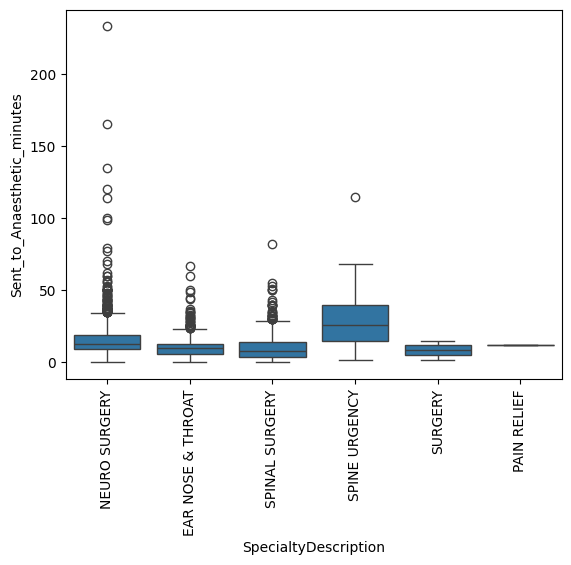